In [1]:
import os
import time

import umap
import anndata
import numpy as np
import pandas as pd
import scanpy as sc

import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from batch_entropy_mixing import batch_entropy_mixing_score


import warnings
warnings.filterwarnings("ignore")

Global seed set to 0


In [2]:
data_file   = "Downloads/mouse_brain_regions.h5ad"
adata = sc.read_h5ad(data_file)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=3000, subset=True,batch_key='study')
adata.obs['final_annotation'] = adata.obs['cell_type']
source = adata[adata.obs['study']=='Rosenberg'].copy()
target = adata[adata.obs['study']!='Rosenberg'].copy()

In [10]:
data = pd.read_csv("D:/GEO/SMILE/H5AD/human_pancreas_data.csv",header=0,index_col=0)
data = data.T
y = pd.read_csv("D:/GEO/SMILE/H5AD/human_pancreas_data_label.csv",header=0,index_col=0)
y.index = data.index
adata = anndata.AnnData(X=data,obs=y)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata = adata[adata.obs['celltype']!='mast']
adata = adata[adata.obs['celltype']!='macrophage']
adata = adata[adata.obs['celltype']!='epsilon']
adata = adata[adata.obs['celltype']!='schwann']

adata.obs['celltype'][adata.obs['celltype']=='acinar']='Pancreas Acinar'
adata.obs['celltype'][adata.obs['celltype']=='alpha']='Pancreas Alpha'
adata.obs['celltype'][adata.obs['celltype']=='beta']='Pancreas Beta'
adata.obs['celltype'][adata.obs['celltype']=='delta']='Pancreas Delta'
adata.obs['celltype'][adata.obs['celltype']=='ductal']='Pancreas Ductal'
adata.obs['celltype'][adata.obs['celltype']=='endothelial']='Pancreas Endothelial'
adata.obs['celltype'][adata.obs['celltype']=='gamma']='Pancreas Gamma'
adata.obs['celltype'][adata.obs['celltype']=='activated_stellate']='Pancreas Stellate'
adata.obs['celltype'][adata.obs['celltype']=='quiescent_stellate']='Pancreas Stellate'

adata.obs['tech'][adata.obs['tech']=='celseq']='Pancreas CelSeq'
adata.obs['tech'][adata.obs['tech']=='celseq2']='Pancreas CelSeq2'
adata.obs['tech'][adata.obs['tech']=='fluidigmc1']='Pancreas Fluidigm C1'
adata.obs['tech'][adata.obs['tech']=='indrop']='Pancreas inDrop'
adata.obs['tech'][adata.obs['tech']=='smartseq2']='Pancreas SS2'

adata.obs['cell_type']=adata.obs['celltype']
adata.obs['study']=adata.obs['tech']
adata.obs['source']='reference'
adata.obs['source'][adata.obs['study']!='Pancreas inDrop']='target'
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=3000, subset=True,batch_key='study')
source = adata[adata.obs['study']=='Pancreas inDrop'].copy()
target = adata[adata.obs['study']!='Pancreas inDrop'].copy()

Trying to set attribute `.obs` of view, copying.
... storing 'orig.ident' as categorical
... storing 'tech' as categorical
... storing 'replicate' as categorical
... storing 'assigned_cluster' as categorical
... storing 'celltype' as categorical
... storing 'dataset' as categorical
... storing 'cell_type' as categorical
... storing 'study' as categorical
... storing 'source' as categorical


In [2]:
data_file   = "Downloads/pbmc_rare_0.003619.h5ad"
adata = sc.read_h5ad(data_file)
adata.obs['cell_type']=adata.obs['final_annotation']
adata.obs['source']='reference'
adata.obs['source'][adata.obs['study']!='Oetjen']='target'
source = adata[adata.obs['study']=='Oetjen'].copy()
target = adata[adata.obs['study']!='Oetjen'].copy()

In [11]:
##run scArches
start_time = time.time()
sca.dataset.setup_anndata(source, batch_key='study', labels_key='cell_type')
vae = sca.models.SCVI(
    source,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)
vae.train(max_epochs=50)
scanvae = sca.models.SCANVI.from_scvi_model(vae, "Unknown")
scanvae.train(max_epochs=10)
ref_path = 'ref_model/'
scanvae.save(ref_path, overwrite=True)

model = sca.models.SCANVI.load_query_data(
    target,
    ref_path,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(target.n_obs)
model._labeled_indices = []
model.train(
    max_epochs=50,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)
print("--- %s mins ---" % int((time.time() - start_time)/60))

INFO     Using batches from adata.obs["study"]                                               
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 8446 cells, 3000 vars, 1 batches, 
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it, loss=734, v_num=1]
INFO     Training for 10 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [00:23<00:00,  2.36s/it, loss=795, v_num=1]
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 6254 cells, 3000 vars, 5 batches, 
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Training for 50 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it, loss=1.28e+03, v_num=1]
--- 2 mins ---


In [4]:
##Fig2a
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target.obs['cell_type'].tolist()
query_latent.obs['predictions'] = model.predict()

print(round(adjusted_rand_score(query_latent.obs['cell_type'],query_latent.obs['predictions']),3))
print(round(f1_score(query_latent.obs['cell_type'],query_latent.obs['predictions'], average='macro'),3))
print(round(accuracy_score(query_latent.obs['cell_type'],query_latent.obs['predictions']),3))

0.857
0.515
0.854


In [4]:
adata.obsm['X_scarches']=np.zeros((adata.X.shape[0],10))
adata.obsm['X_scarches'][adata.obs['study']=='Oetjen',:]=scanvae.get_latent_representation()
adata.obsm['X_scarches'][adata.obs['study']!='Oetjen',:]=model.get_latent_representation()

adata.obs['Annotation']='Unlabel'
adata.obs['Annotation'][adata.obs['study']=='Oetjen']=source.obs['cell_type']
adata.obs['Annotation'][adata.obs['study']!='Oetjen']=model.predict()
adata.obs['scArches']=adata.obs['Annotation']

In [12]:
adata.obsm['X_scarches']=np.zeros((adata.X.shape[0],10))
adata.obsm['X_scarches'][adata.obs['study']=='Pancreas inDrop',:]=scanvae.get_latent_representation()
adata.obsm['X_scarches'][adata.obs['study']!='Pancreas inDrop',:]=model.get_latent_representation()

adata.obs['Annotation']='Unlabel'
adata.obs['Annotation'][adata.obs['study']=='Pancreas inDrop']=source.obs['cell_type']
adata.obs['Annotation'][adata.obs['study']!='Pancreas inDrop']=model.predict()
adata.obs['scArches']=adata.obs['Annotation']

In [5]:
adata.obsm['X_scarches']=np.zeros((adata.X.shape[0],10))
adata.obsm['X_scarches'][adata.obs['study']=='Rosenberg',:]=scanvae.get_latent_representation()
adata.obsm['X_scarches'][adata.obs['study']!='Rosenberg',:]=model.get_latent_representation()

adata.obs['Annotation']='Unlabel'
adata.obs['Annotation'][adata.obs['study']=='Rosenberg']=source.obs['cell_type']
adata.obs['Annotation'][adata.obs['study']!='Rosenberg']=model.predict()
adata.obs['scArches']=adata.obs['Annotation']

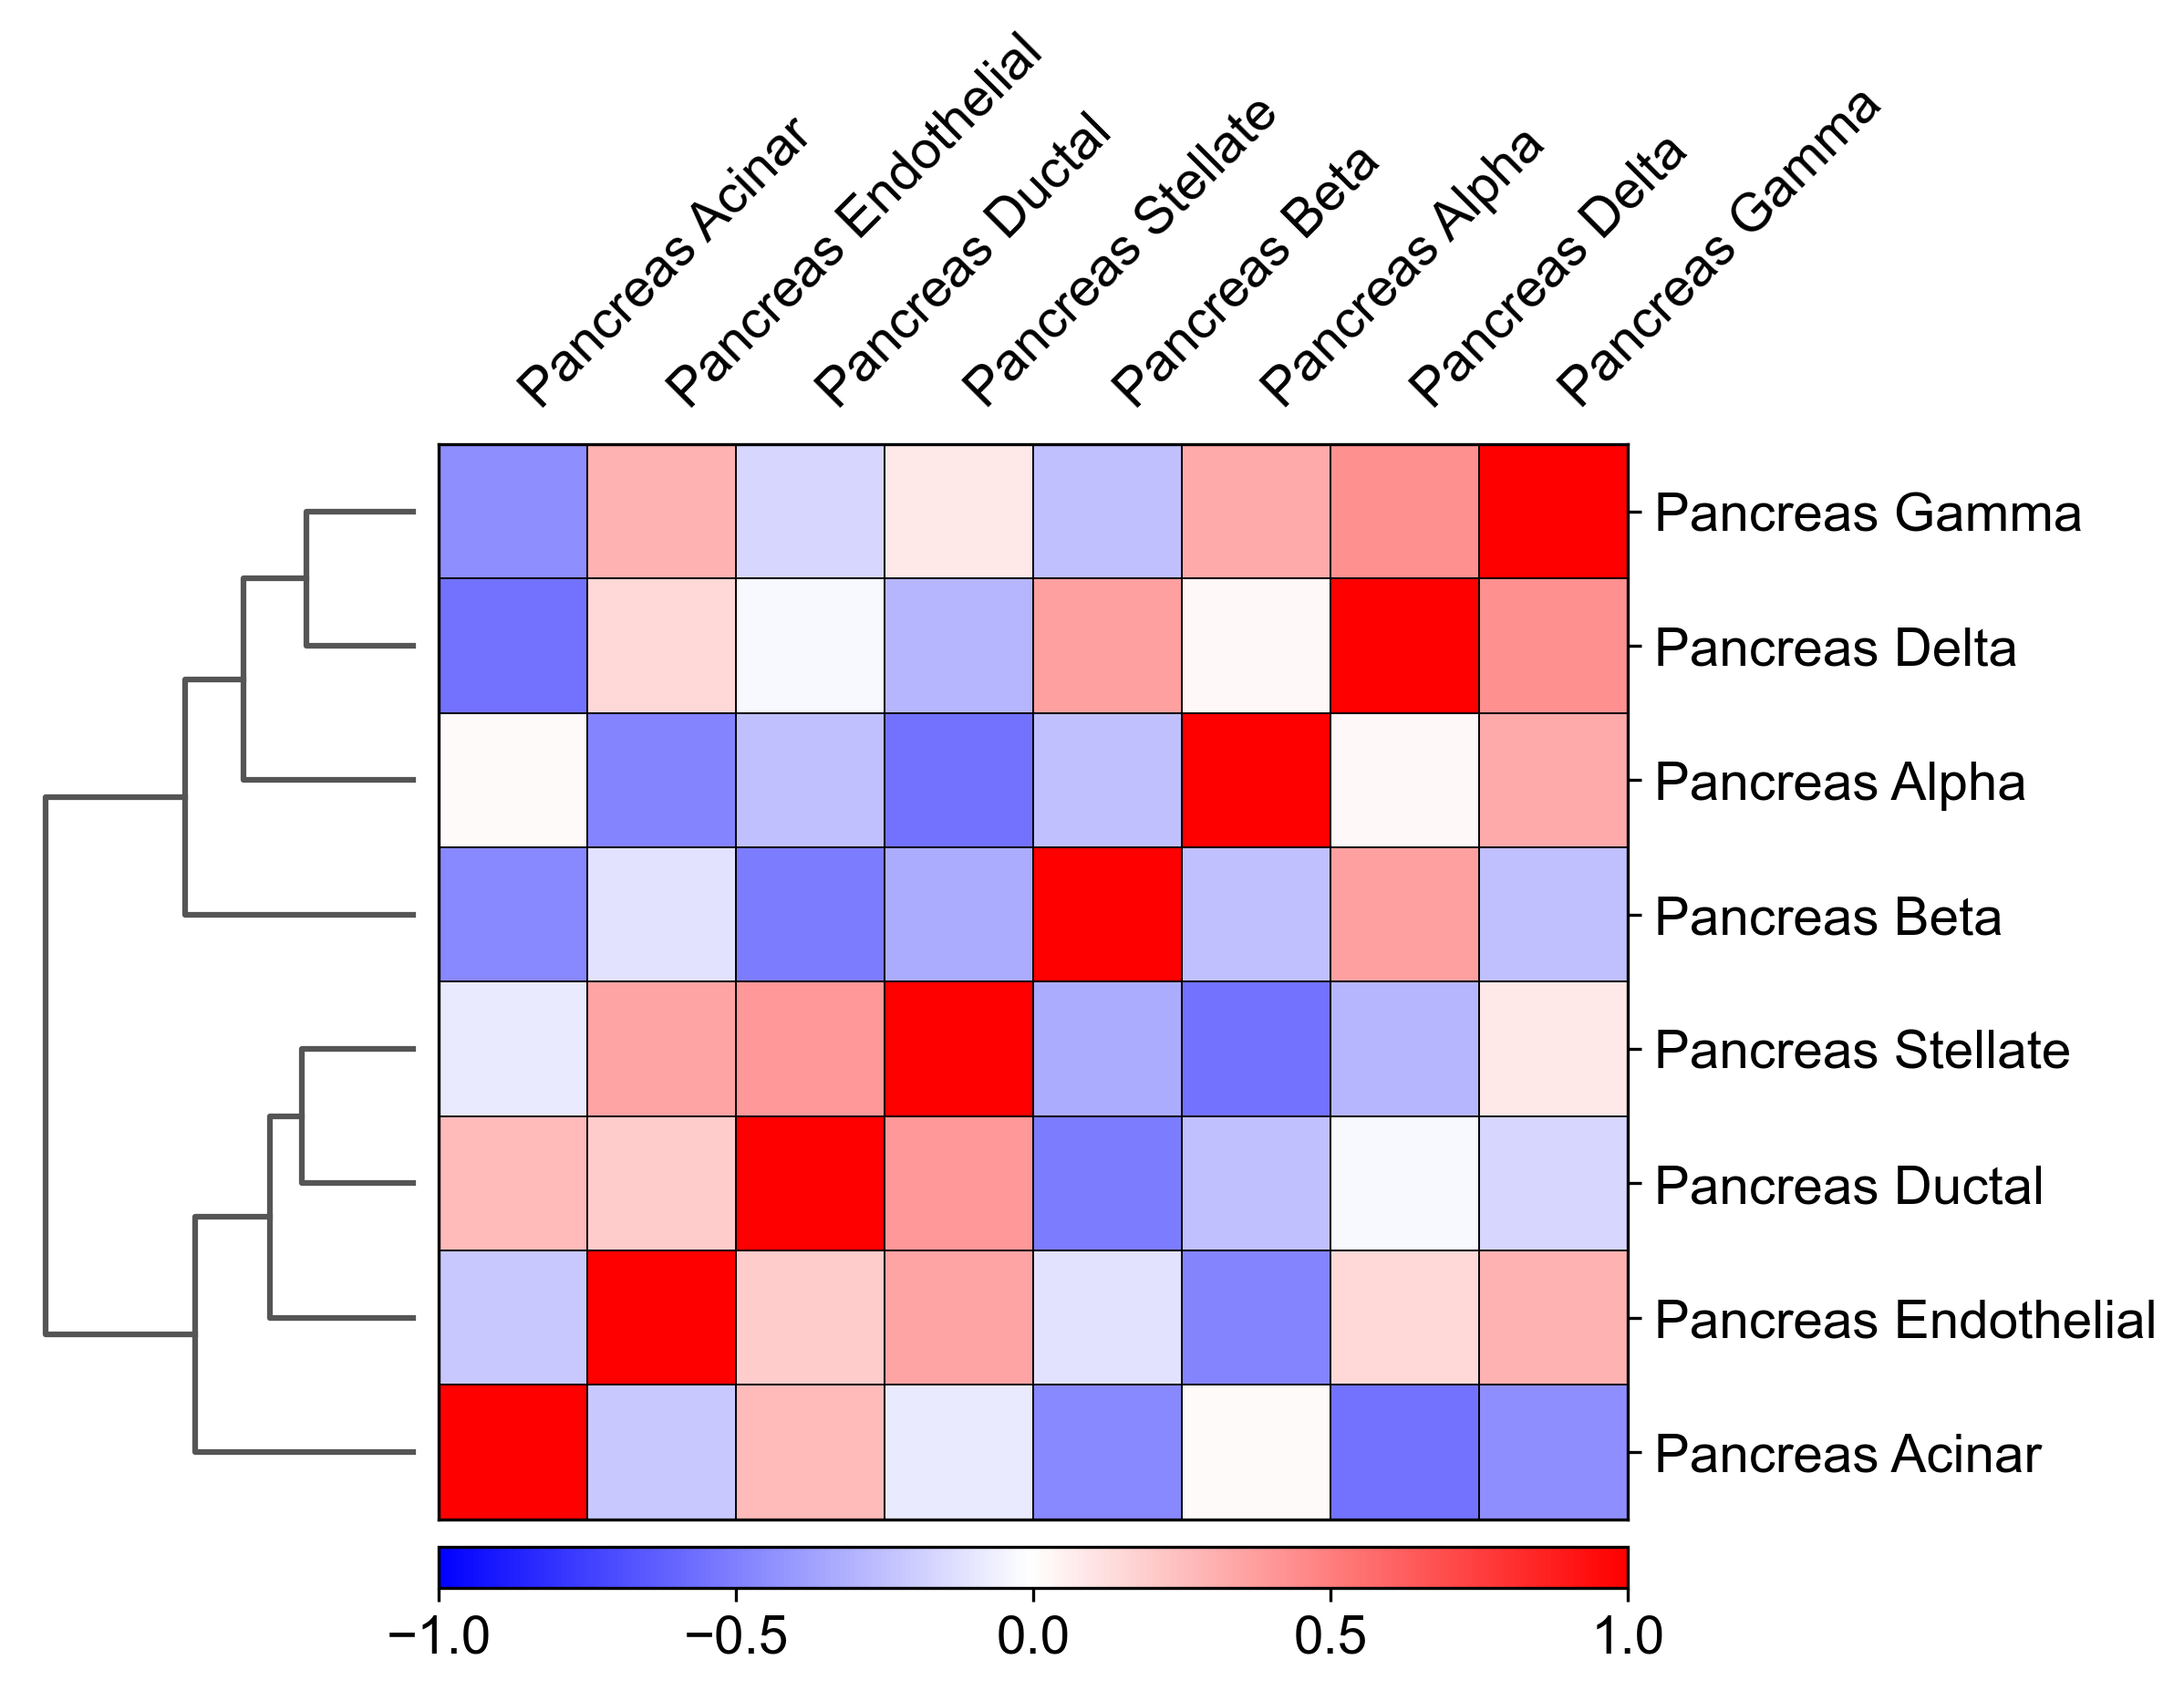

In [13]:
adata.obs['scArches']= pd.Series(adata.obs['scArches'].values, dtype="category").values
#sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_score')
sc.tl.dendrogram(adata, 'scArches', use_rep='X_scarches',cor_method='spearman', linkage_method='ward')
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150)
sc.pl.correlation_matrix(adata, 'scArches', figsize=(7.5,5.5),save='pancreas_scArches_corr.svg')

... storing 'source' as categorical
... storing 'Annotation' as categorical
... storing 'scArches' as categorical


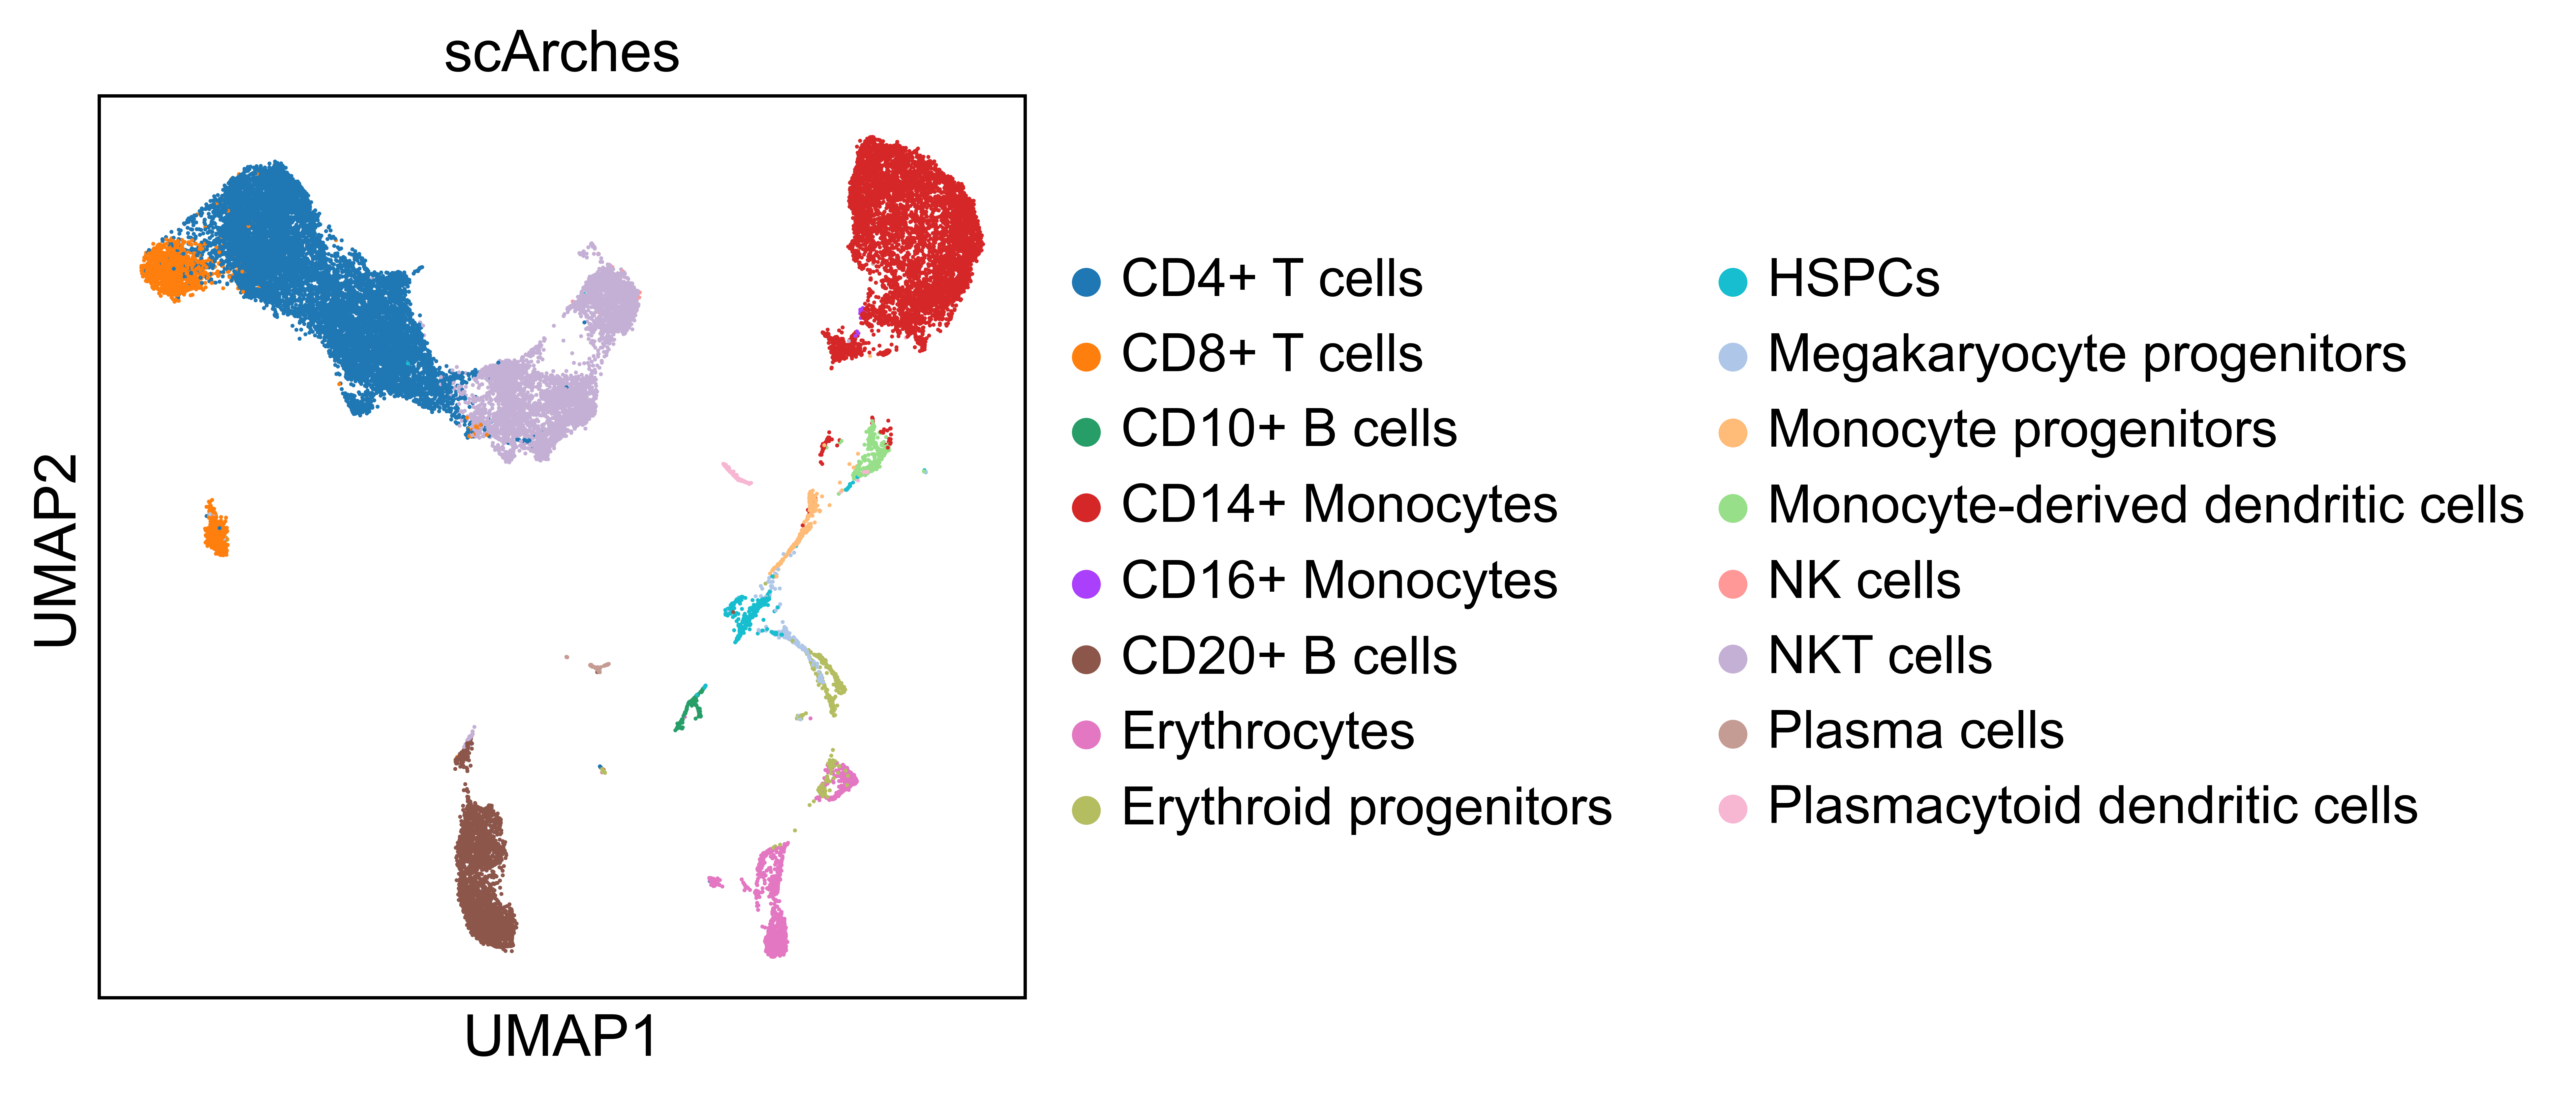

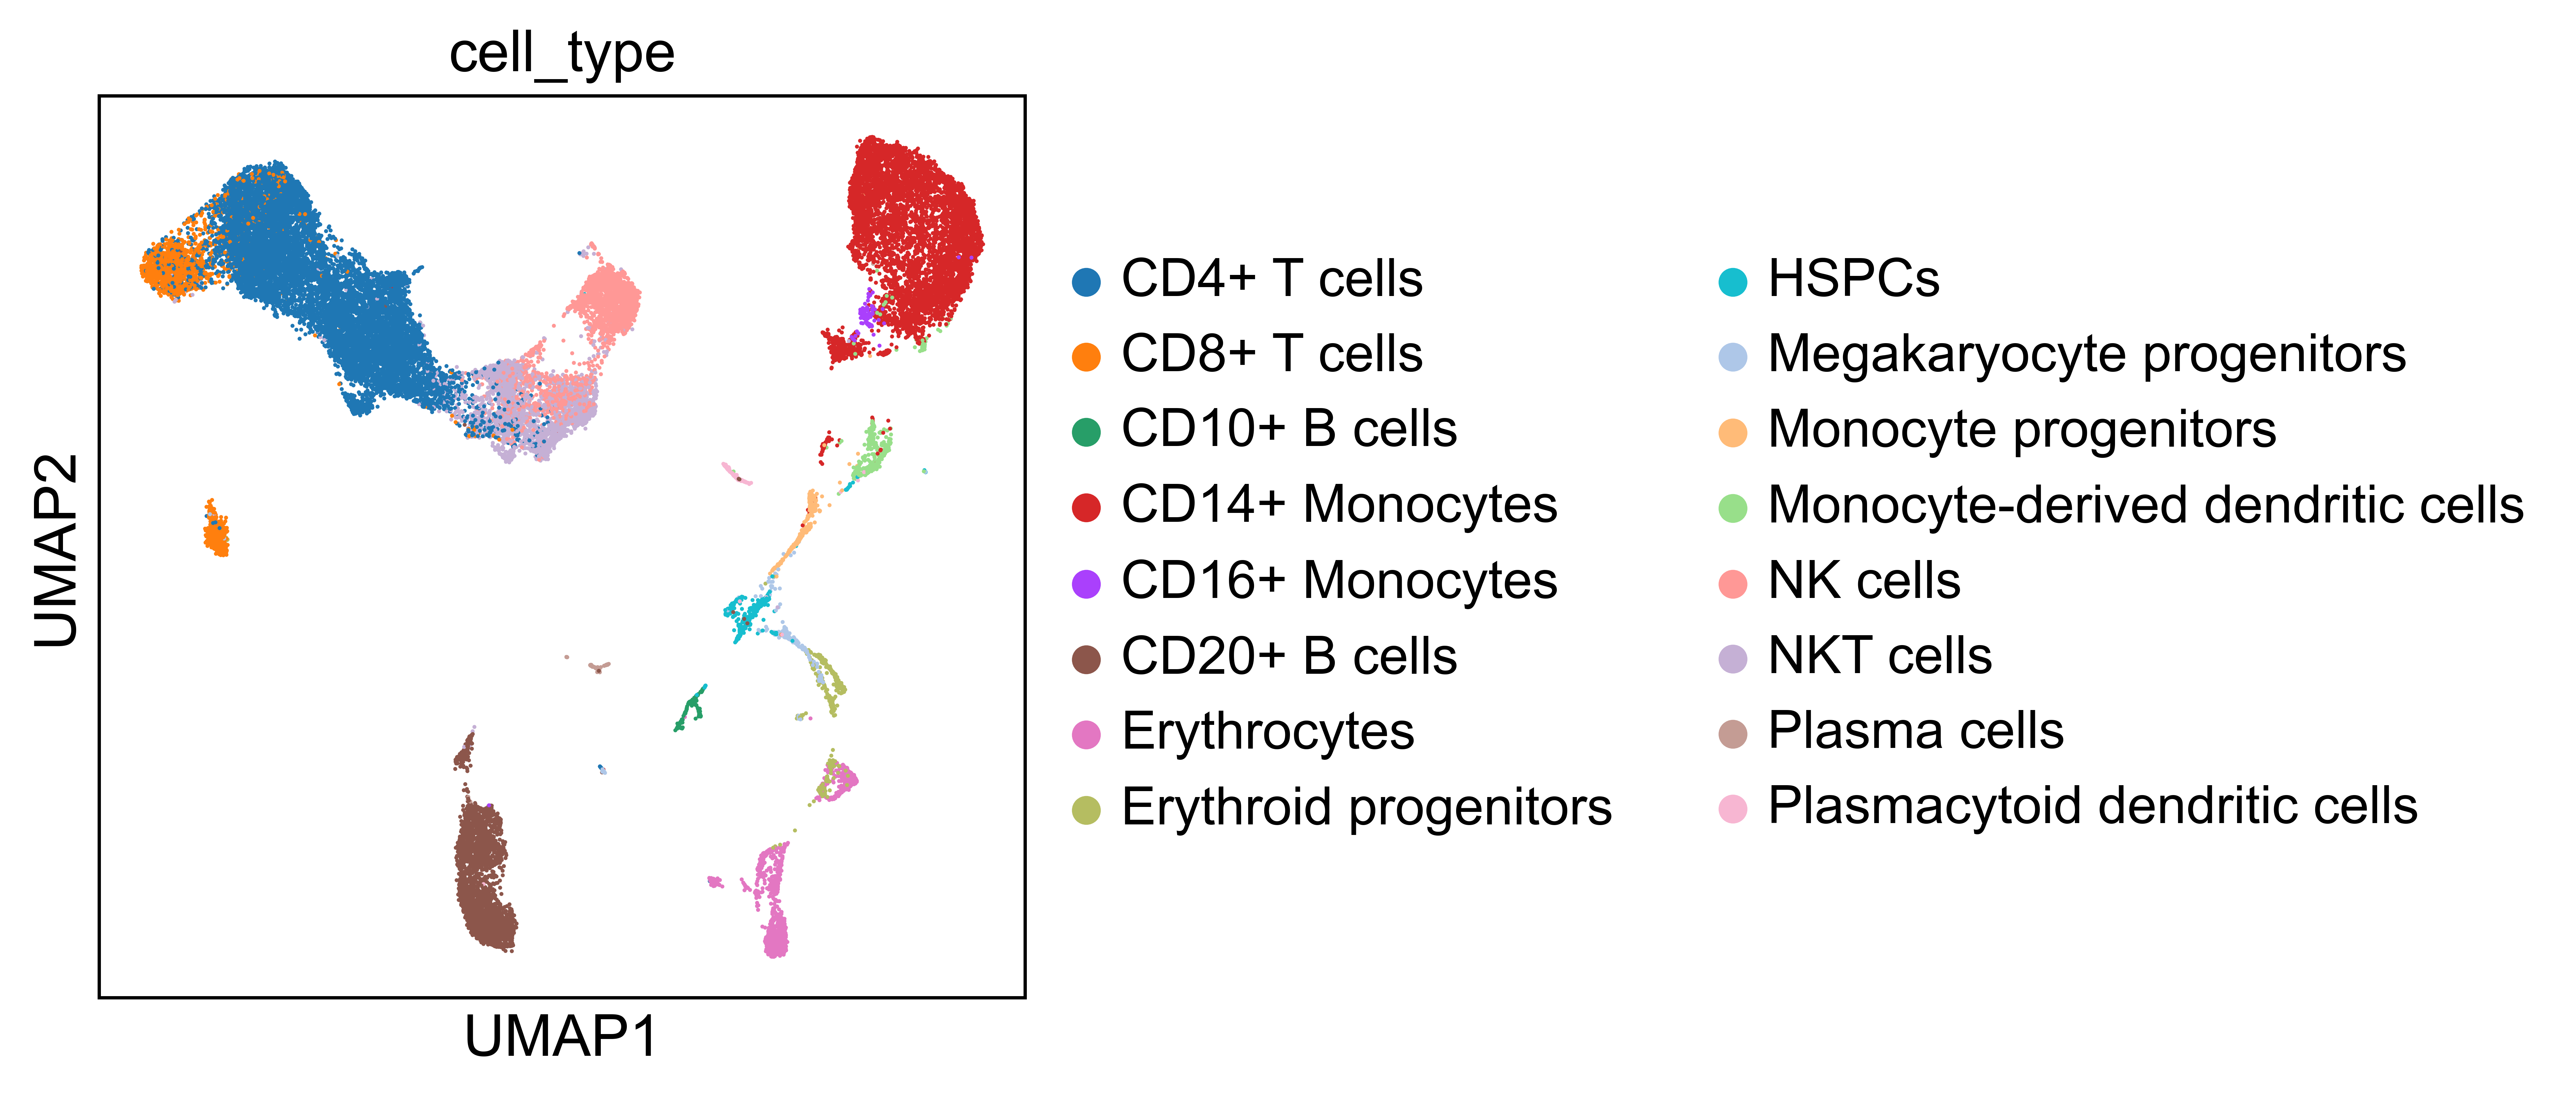

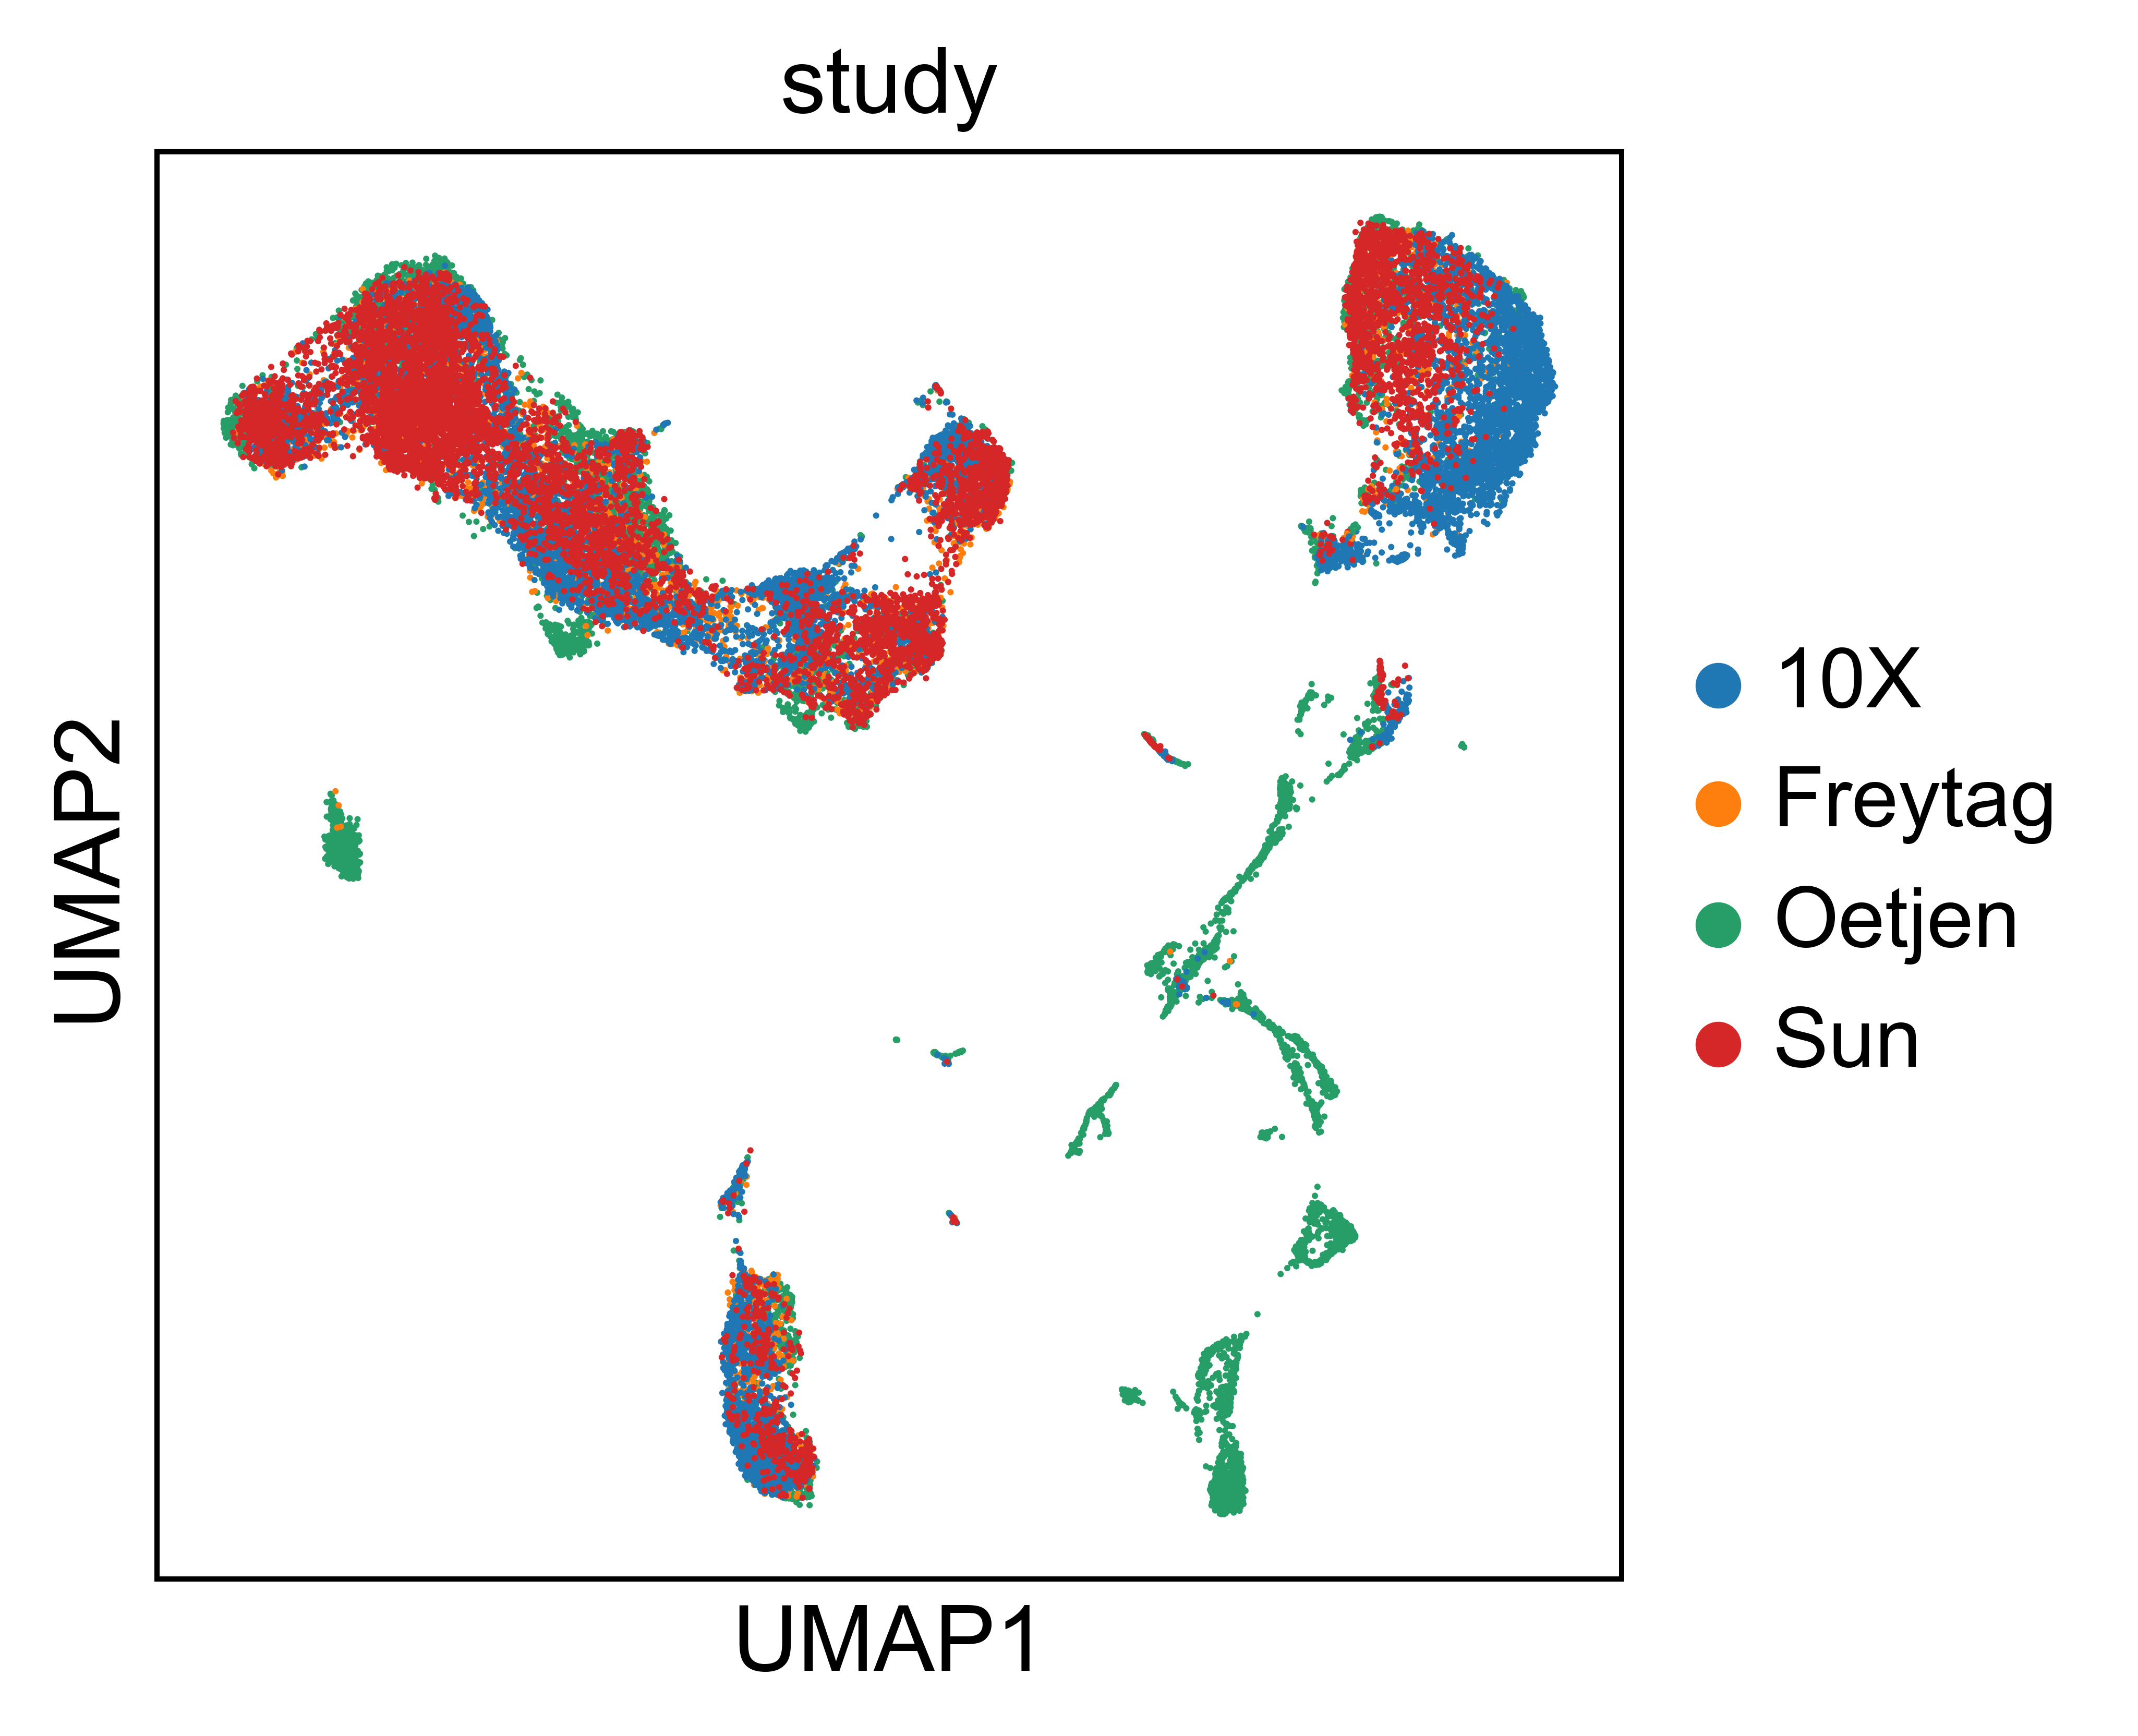

In [6]:
##supplementary fig5
down_samp = pd.DataFrame(adata.obsm['X_scarches'])
#down_samp = down_samp.sample(frac=0.1)
umaps = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2,
                  metric="cosine").fit(down_samp.values)
embedding = umaps.transform(adata.obsm['X_scarches'])
embedding = pd.DataFrame(embedding)
embedding.columns=['UMAP1','UMAP2']
adata.obsm['X_umap'] = embedding.iloc[:,:2].values

sc.set_figure_params(scanpy=True, dpi=450, dpi_save=450)
sc.pl.umap(adata, color=['scArches'],save='PBMC_annotation_scArches.svg')
sc.pl.umap(adata, color=["cell_type"],save='PBMC_celltype_scArches.svg')
sc.pl.umap(adata, color=["study"],save='PBMC_batch_scArches.svg')

In [7]:
##Fig2c
subsample = adata.copy()
#sc.pp.subsample(subsample, fraction=0.1)
print(silhouette_score(subsample.obsm['X_umap'],subsample.obs['cell_type']))
print(batch_entropy_mixing_score(subsample.obsm['X_umap'],subsample.obs['study']))

0.33426577
0.4433793050085687
